In [1]:
%matplotlib widget

In [5]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
from mnist import MNIST  # run from Anaconda shell: pip install python-mnist
import sklearn
import sklearn.metrics
from sklearn.model_selection import KFold

# setup plotting 
from IPython import get_ipython
import psutil
inTerminal = not "IPKernelApp" in get_ipython().config
inJupyterNb = any(filter(lambda x: x.endswith("jupyter-notebook"), psutil.Process().parent().cmdline()))
get_ipython().run_line_magic("matplotlib", "" if inTerminal else "notebook" if inJupyterNb else "widget")
def nextplot():
    if inTerminal:
        plt.clf()     # this clears the current plot
    else:
        plt.figure()  # this creates a new plot 

# Load the data

In [6]:
mndata = MNIST("data/")
X, y = mndata.load_training()
y = np.array(y, dtype="uint8")
X = np.array([np.array(x) for x in X], dtype="uint8")
N, D = X.shape
Xtest, ytest = mndata.load_testing()
ytest = np.array(ytest, dtype="uint8")
Xtest = np.array([np.array(x) for x in Xtest], dtype="uint8")
Ntest = Xtest.shape[0]

In [7]:
# Optional: use a smaller sample of the data
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(y == c)[0], size=100, replace=False))
X_s = X[p, :]
y_s = y[p]
N_s = X_s.shape[0]
p = np.zeros(0, dtype="int")
for c in range(10):
    p = np.append(p, np.random.choice(np.where(ytest == c)[0], size=10, replace=False))
Xtest_s = Xtest[p, :]
ytest_s = ytest[p]
Ntest_s = Xtest_s.shape[0]

In [8]:
def showdigit(x):
    "Show one digit as a gray-scale image."
    plt.imshow(x.reshape(28, 28), norm=mpl.colors.Normalize(0, 255), cmap="gray")

<IPython.core.display.Javascript object>


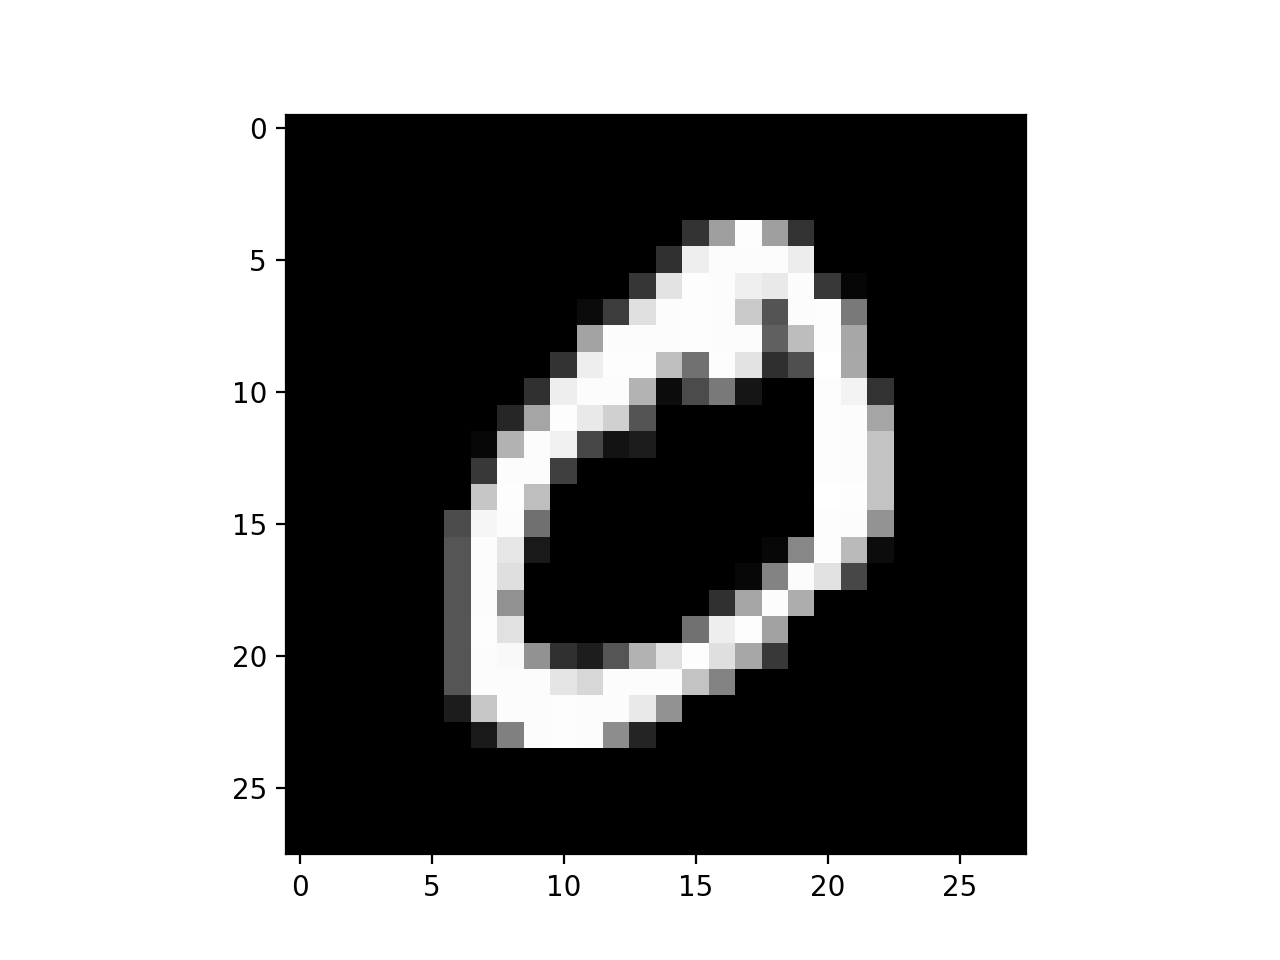

0


In [9]:
# Example: show first digit
nextplot()
showdigit(X[1,])
print(y[1])

In [10]:
def showdigits(X, y, max_digits=15):
    "Show up to max_digits random digits per class from X with class labels from y."
    num_cols = min(max_digits, max(np.bincount(y)))
    for c in range(10):
        ii = np.where(y == c)[0]
        if len(ii) > max_digits:
            ii = np.random.choice(ii, size=max_digits, replace=False)
        for j in range(num_cols):
            ax = plt.gcf().add_subplot(
                10, num_cols, c * num_cols + j + 1, aspect="equal"
            )
            ax.get_xaxis().set_visible(False)
            if j == 0:
                ax.set_ylabel(c)
                ax.set_yticks([])
            else:
                ax.get_yaxis().set_visible(False)
            if j < len(ii):
                ax.imshow(
                    X[ii[j],].reshape(28, 28),
                    norm=mpl.colors.Normalize(0, 255),
                    cmap="gray",
                )
            else:
                ax.axis("off")

<IPython.core.display.Javascript object>


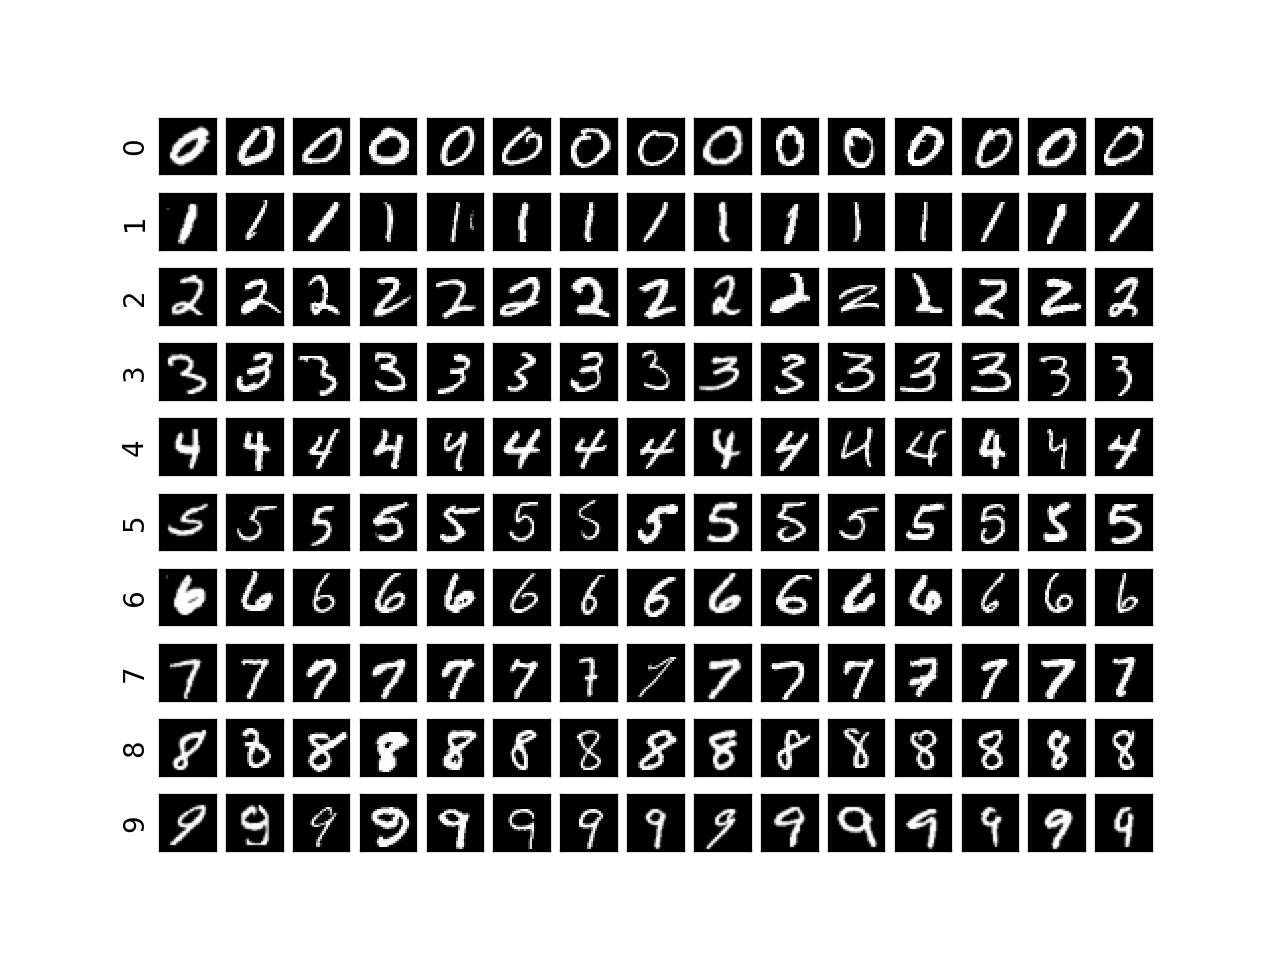

In [11]:
# Example: show 15 random digits per class from training data
nextplot()
showdigits(X, y)

<IPython.core.display.Javascript object>


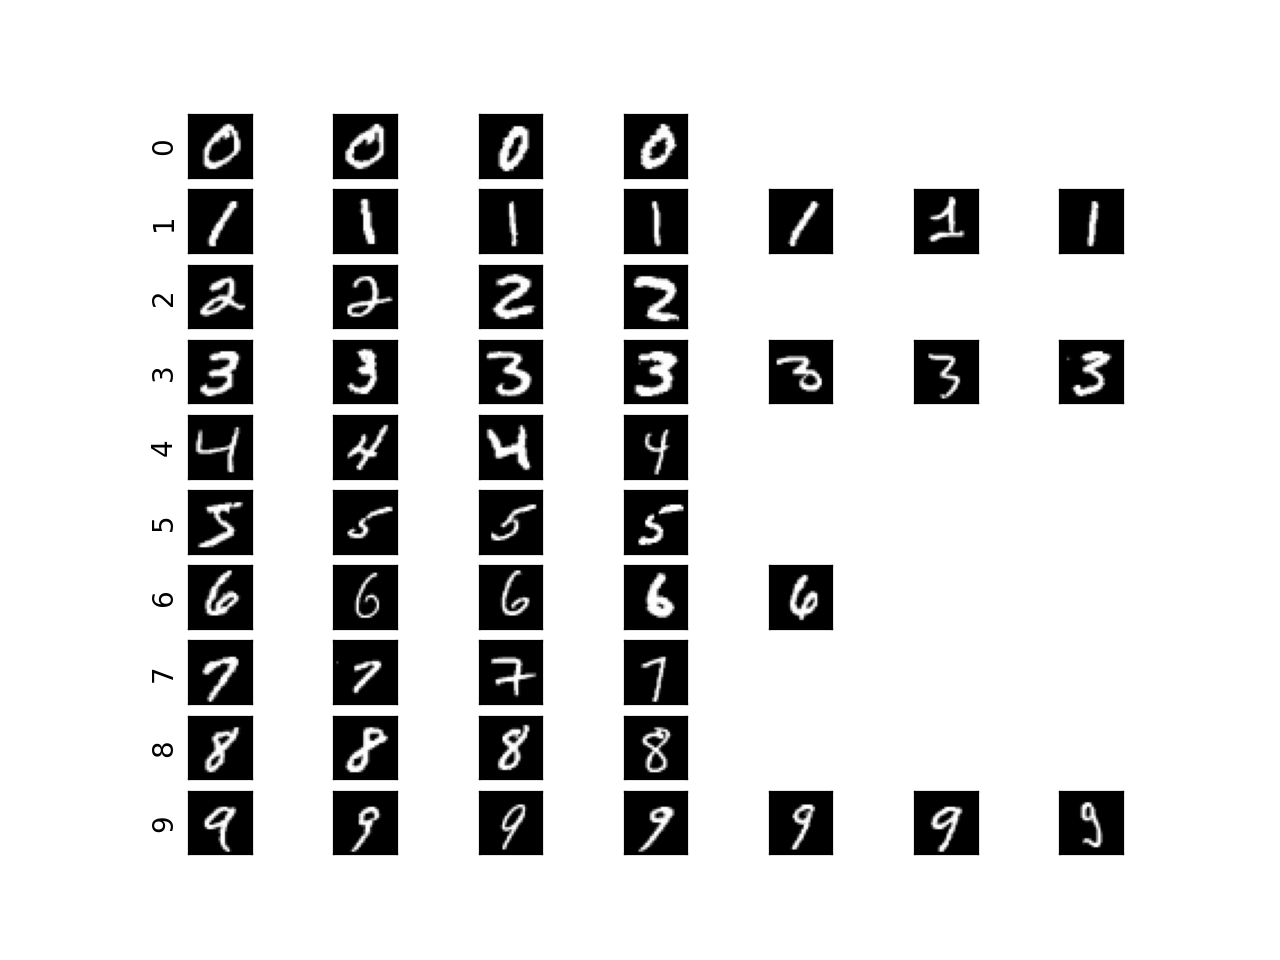

In [12]:
# Example: show a specific set of digits
nextplot()
showdigits(X[0:50,], y[0:50])

In [13]:
# A simple example dataset that you can use for testing
Xex = np.array([1, 0, 0, 1, 1, 1, 2, 0]).reshape(4, 2)
yex = np.array([0, 1, 2, 0])

# 1 Training

In [14]:
def nb_train(X, y, alpha=1, K=None, C=None):
    """Train a Naive Bayes model.

    We assume that all features are encoded as integers and have the same domain
    (set of possible values) from 0:(K-1). Similarly, class labels have domain
    0:(C-1).

    Parameters
    ----------
    X : ndarray of shape (N,D)
        Design matrix.
    y : ndarray of shape (N,)
        Class labels.
    alpha : int
        Parameter for symmetric Dirichlet prior (Laplace smoothing) for all
        fitted distributions.
    K : int
        Each feature takes values in [0,K-1]. None means auto-detect.
    C : int
        Each class label takes values in [0,C-1]. None means auto-detect.

    Returns
    -------
    A dictionary with the following keys and values:

    logpriors : ndarray of shape (C,)
        Log prior probabilities of each class such that logpriors[c] contains
        the log prior probability of class c.

    logcls : ndarray of shape(C,D,K)
        A class-by-feature-by-value array of class-conditional log-likelihoods
        such that logcls[c,j,v] contains the conditional log-likelihood of value
        v in feature j given class c.
    """
    N, D = X.shape
    if K is None:
        K = np.max(X) + 1
    if C is None:
        C = np.max(y) + 1

    # Compute class priors and store them in priors
    priors = np.zeros(C)
    # YOUR CODE HERE
    map_alpha = alpha - 1
    class_counts = np.unique(y, return_counts=True)[1] + map_alpha
    total_class_count = sum(class_counts)
    priors = class_counts / total_class_count
    
    # Compute class-conditional densities in a class x feature x value array
    # and store them in cls.
    cls = np.zeros((C, D, K))
    # YOUR CODE HERE
    for c in np.unique(y, return_counts=True)[0]:
        indexes = np.where(y==c)[0]
        current_X = X[indexes]
        
        for d in range(0, D):
            current_col = current_X[:, d]
            
            for k in range(0, K):
                count_k = len(current_col[current_col==k]) + map_alpha
                cls[c][d][k] = count_k
            cls[c][d] = cls[c][d] / sum(cls[c][d])
            
    # Output result
    return dict(logpriors=np.log(priors), logcls=np.log(cls))

In [15]:
# Test your code (there should be a warning when you run this)
model = nb_train(Xex, yex, alpha=1)
model
# This should produce:
# {'logcls': array([[[       -inf, -0.69314718, -0.69314718],
#          [ 0.        ,        -inf,        -inf]],
#
#         [[ 0.        ,        -inf,        -inf],
#          [       -inf,  0.        ,        -inf]],
#
#         [[       -inf,  0.        ,        -inf],
#          [       -inf,  0.        ,        -inf]]]),
#  'logpriors': array([-0.69314718, -1.38629436, -1.38629436])}

/var/folders/0s/63ktljj55t12qgn_8z4nq4wm0000gn/T/ipykernel_40648/702186100.py:66: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))


{'logpriors': array([-0.69314718, -1.38629436, -1.38629436]),
 'logcls': array([[[       -inf, -0.69314718, -0.69314718],
         [ 0.        ,        -inf,        -inf]],
 
        [[ 0.        ,        -inf,        -inf],
         [       -inf,  0.        ,        -inf]],
 
        [[       -inf,  0.        ,        -inf],
         [       -inf,  0.        ,        -inf]]])}

In [16]:
# Test your code (this time no warning)
model = nb_train(Xex, yex, alpha=2)  # here we use add-one smoothing
model
# This should produce:
# {'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
#          [-0.51082562, -1.60943791, -1.60943791]],
#
#         [[-0.69314718, -1.38629436, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]],
#
#         [[-1.38629436, -0.69314718, -1.38629436],
#          [-1.38629436, -0.69314718, -1.38629436]]]),
#  'logpriors': array([-0.84729786, -1.25276297, -1.25276297])}

{'logpriors': array([-0.84729786, -1.25276297, -1.25276297]),
 'logcls': array([[[-1.60943791, -0.91629073, -0.91629073],
         [-0.51082562, -1.60943791, -1.60943791]],
 
        [[-0.69314718, -1.38629436, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]],
 
        [[-1.38629436, -0.69314718, -1.38629436],
         [-1.38629436, -0.69314718, -1.38629436]]])}

# 2 Prediction

In [17]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each column.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x - offset), axis=0))

#log P(Y=yhat | X=x) = log P(Y=yhat, X=x) - log P(X=x)

In [18]:
def nb_predict(model, Xnew):
    """Predict using a Naive Bayes model.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    Xnew : nd_array of shape (Nnew,D)
        New data to predict.

    Returns
    -------
    A dictionary with the following keys and values:

    yhat : nd_array of shape (Nnew,)
        Predicted label for each new data point.

    logprob : nd_array of shape (Nnew,)
        Log-probability of the label predicted for each new data point.
    """
    logpriors = model["logpriors"]
    logcls = model["logcls"]
    Nnew = Xnew.shape[0]
    C, D, K = logcls.shape

    # Compute the unnormalized log joint probabilities P(Y=c, x_i) of each
    # test point (row i) and each class (column c); store in logjoint
    logjoint = np.zeros((Nnew, C))
    # YOUR CODE HERE
    
    for row in range(Nnew):
        for c in range(C):
            logjoint[row, c] = logpriors[c]
            
            for feature in range(D):
                value_k = Xnew[row, feature]
                logjoint[row, c] = logjoint[row, c] + logcls[c, feature, value_k]
            
    # Compute predicted labels (in "yhat") and their log probabilities
    # P(yhat_i | x_i) (in "logprob")
    # YOUR CODE HERE
    yhat = np.argmax(logjoint, axis=1)
    
    px = logsumexp(logjoint.T) 
    logprobs = logjoint - px.reshape((logjoint.shape[0], 1))
    logprob = np.max(logprobs, axis=1)

    return dict(yhat=yhat, logprob=logprob)

In [19]:
# Test your code
model = nb_train(Xex, yex, alpha=2)
nb_predict(model, Xex)
# This should produce:
# {'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486]),
#  'yhat': array([0, 1, 2, 0], dtype=int64)}

{'yhat': array([0, 1, 2, 0]),
 'logprob': array([-0.41925843, -0.55388511, -0.68309684, -0.29804486])}

# 3 Experiments on MNIST Digits Data

In [20]:
# Let's train the model on the digits data and predict
model_nb2 = nb_train(X, y, alpha=2)
pred_nb2 = nb_predict(model_nb2, Xtest)
yhat = pred_nb2["yhat"]
logprob = pred_nb2["logprob"]

In [21]:
# Accuracy
sklearn.metrics.accuracy_score(ytest, yhat)

0.8363

<IPython.core.display.Javascript object>


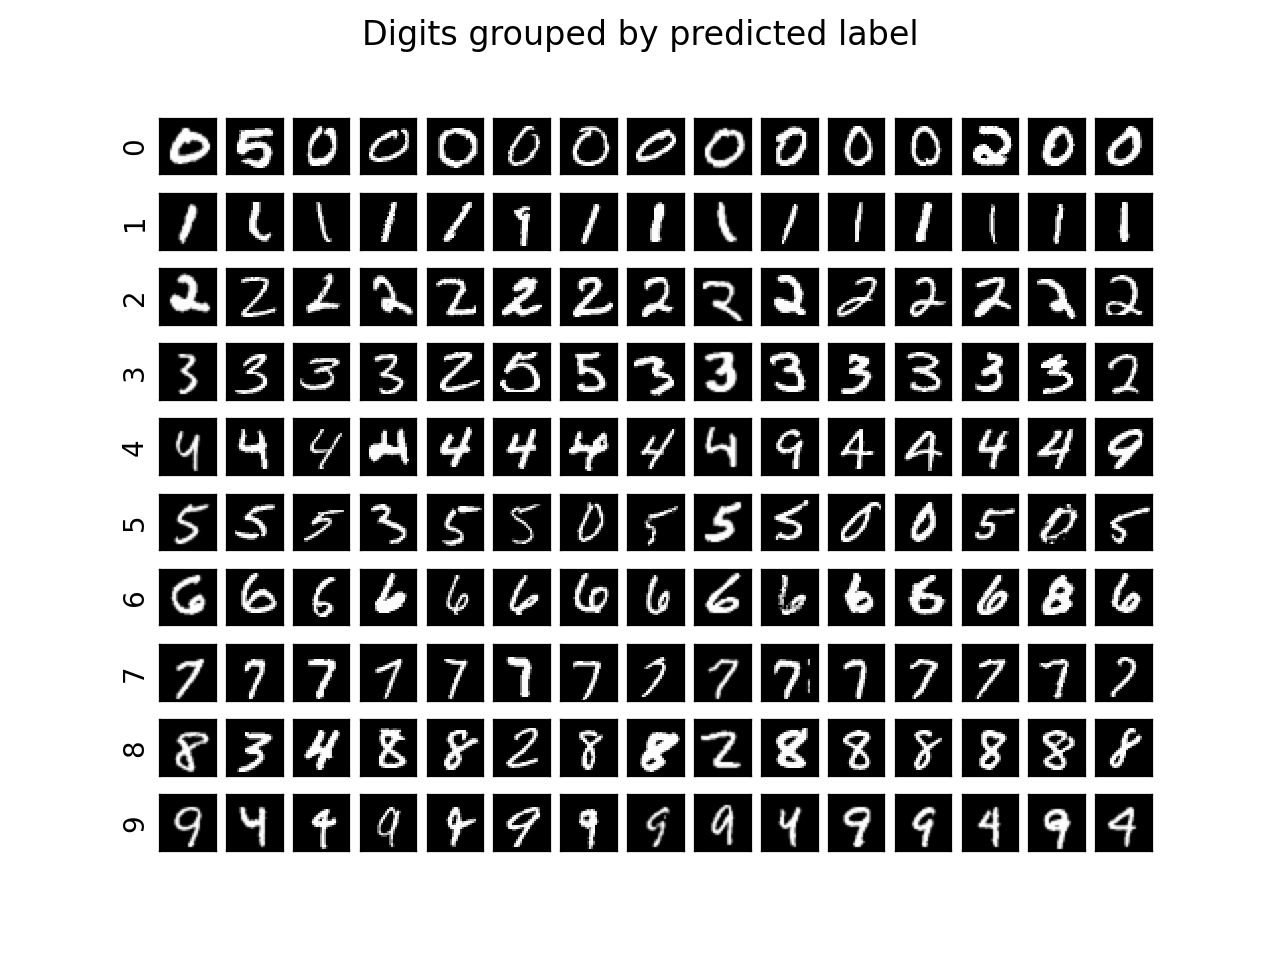

Text(0.5, 0.98, 'Digits grouped by predicted label')

In [22]:
# show some digits grouped by prediction; can you spot errors?
nextplot()
showdigits(Xtest, yhat)
plt.suptitle("Digits grouped by predicted label")

<IPython.core.display.Javascript object>


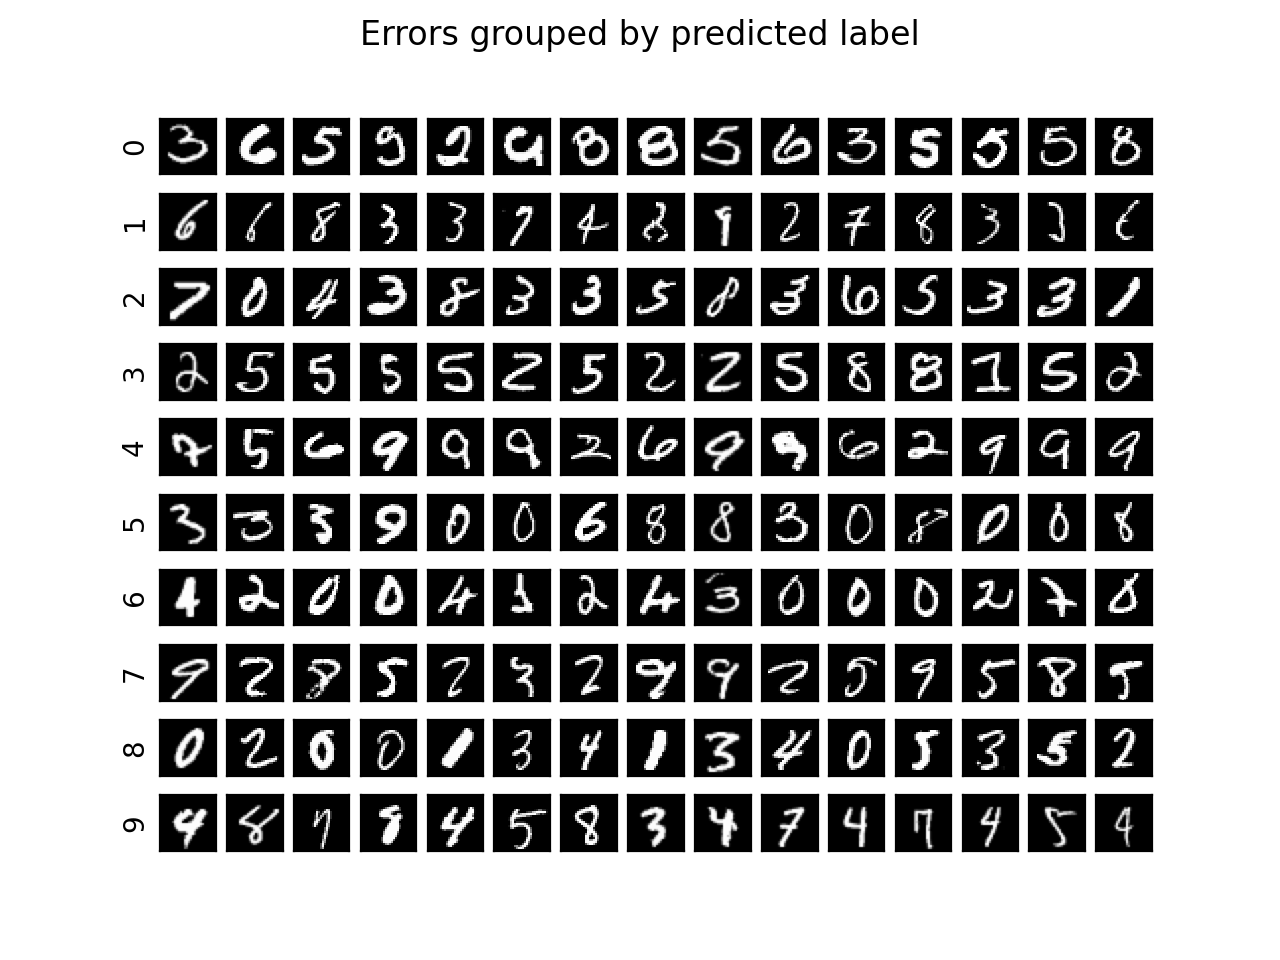

Text(0.5, 0.98, 'Errors grouped by predicted label')

In [23]:
# do the same, but this time show wrong predicitions only
perror = ytest != yhat
nextplot()
showdigits(Xtest[perror, :], yhat[perror])
plt.suptitle("Errors grouped by predicted label")

<IPython.core.display.Javascript object>


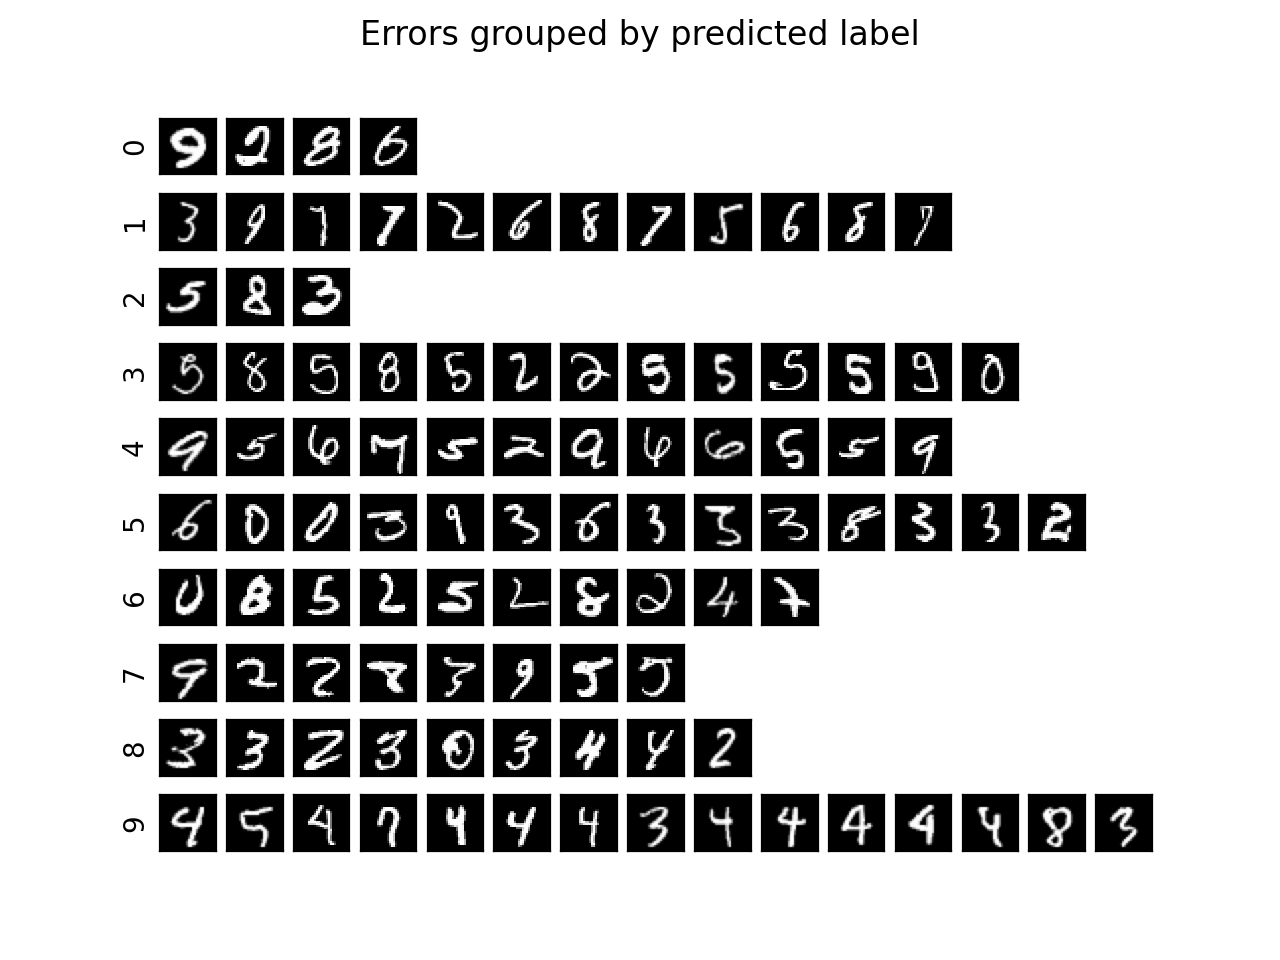

Text(0.5, 0.98, 'Errors grouped by predicted label')

In [24]:
# do the same, but this time on a sample of wrong preditions to see
# error proportions
ierror_s = np.random.choice(np.where(perror)[0], 100, replace=False)
nextplot()
showdigits(Xtest[ierror_s, :], yhat[ierror_s])
plt.suptitle("Errors grouped by predicted label")

In [25]:
# now let's look at this in more detail
print(sklearn.metrics.classification_report(ytest, yhat))
print(sklearn.metrics.confusion_matrix(ytest, yhat))  # true x predicted

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       980
           1       0.86      0.97      0.91      1135
           2       0.89      0.79      0.84      1032
           3       0.77      0.83      0.80      1010
           4       0.82      0.82      0.82       982
           5       0.78      0.67      0.72       892
           6       0.88      0.89      0.89       958
           7       0.91      0.84      0.87      1028
           8       0.79      0.78      0.79       974
           9       0.75      0.85      0.80      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.83      0.83     10000
weighted avg       0.84      0.84      0.84     10000

[[ 872    0    3    5    3   63   18    1   14    1]
 [   0 1102    8    3    0    3    4    0   15    0]
 [  15   28  816   37   26    8   31   18   49    4]
 [   4   22   28  835    1   29   10   14   45   22]
 [   2    8    6    1  808   

<IPython.core.display.Javascript object>


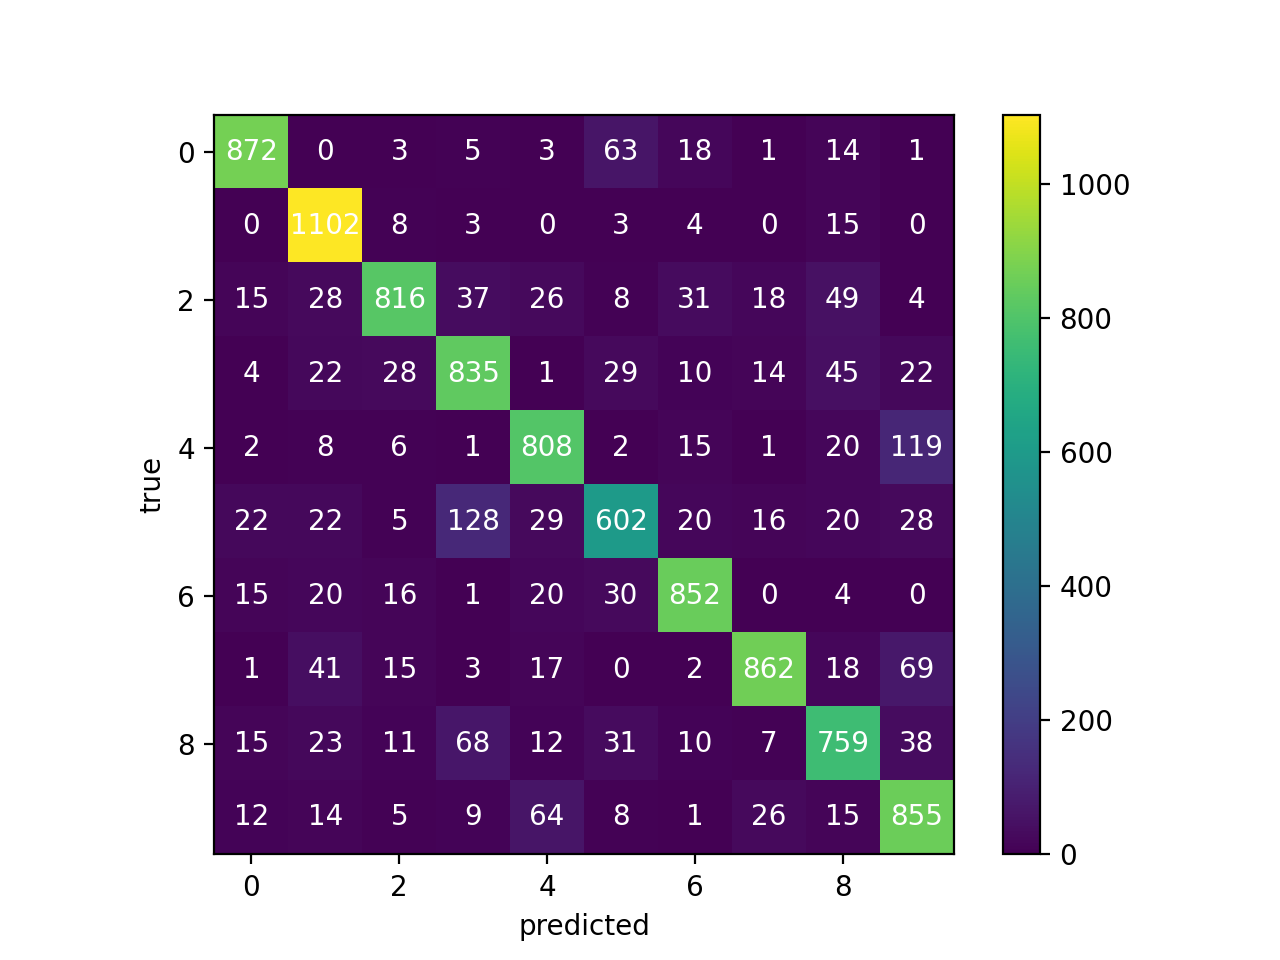

In [26]:
# plot the confusion matrix
nextplot()
M = sklearn.metrics.confusion_matrix(ytest, yhat)
plt.imshow(M, origin="upper")
for ij, v in np.ndenumerate(M):
    i, j = ij
    plt.text(j, i, str(v), color="white", ha="center", va="center")
plt.xlabel("predicted")
plt.ylabel("true")
plt.colorbar()

<IPython.core.display.Javascript object>


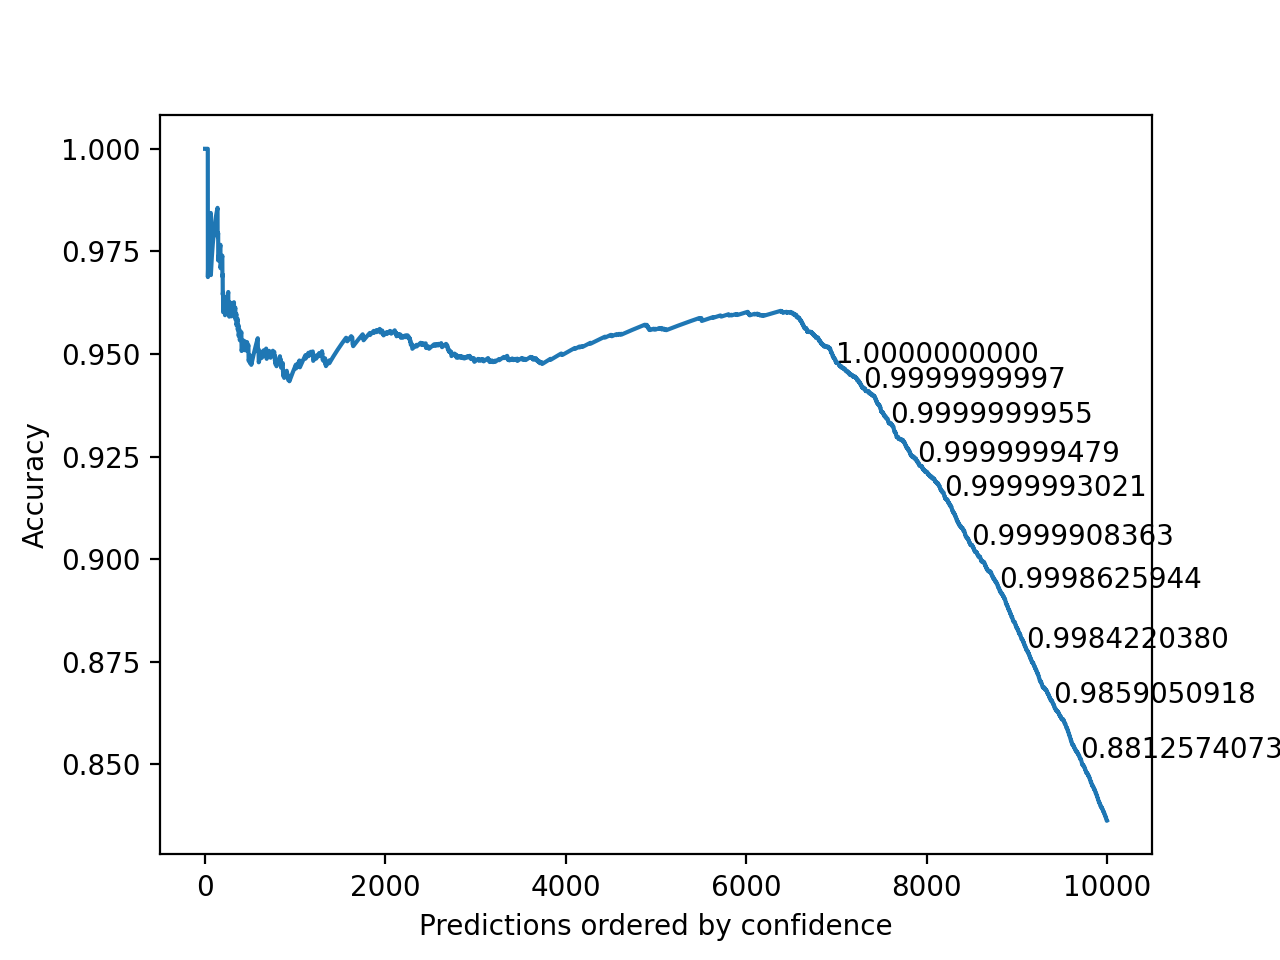

0.9999999999822649
0.9999999996949782
0.9999999955447265
0.9999999478873192
0.999999302093004
0.9999908362580441
0.9998625944161882
0.9984220379937704
0.9859050917808865
0.8812574072791101


In [27]:
# cumulative accuracy for predictions ordered by confidence (labels show predicted
# confidence)
order = np.argsort(logprob)[::-1]
accuracies = np.cumsum(ytest[order] == yhat[order]) / (np.arange(len(yhat)) + 1)
nextplot()
plt.plot(accuracies)
plt.xlabel("Predictions ordered by confidence")
plt.ylabel("Accuracy")
for x in np.linspace(0.7, 1, 10, endpoint=False):
    index = int(x * (accuracies.size - 1))
    print(np.exp(logprob[order][index]))
    plt.text(index, accuracies[index], "{:.10f}".format(np.exp(logprob[order][index])))

<IPython.core.display.Javascript object>


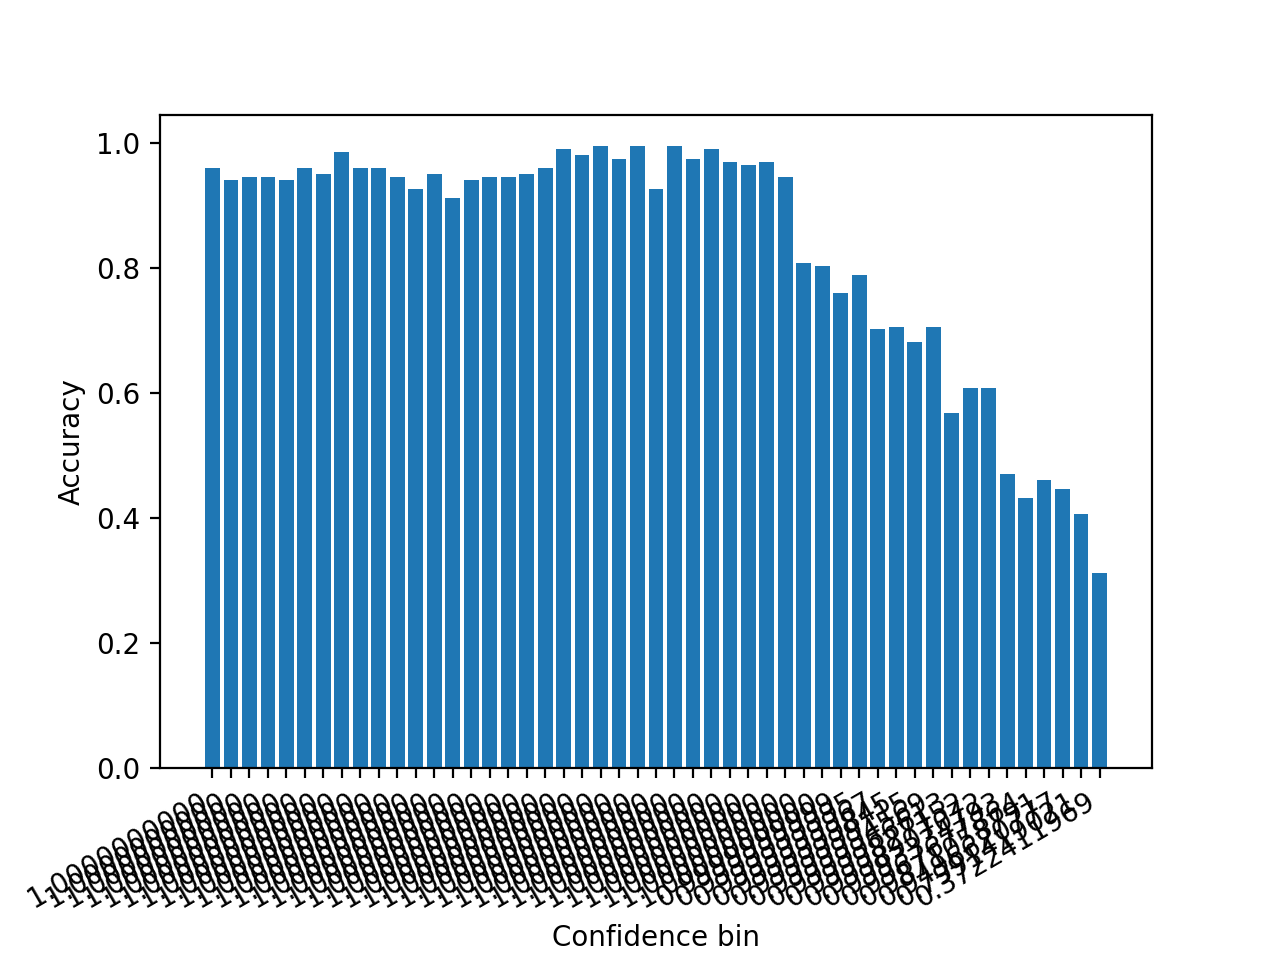

Text(0, 0.5, 'Accuracy')

In [28]:
# Accuracy for predictions grouped by confidence (labels show
# predicted confidence). Make the plot large (or reduce number of bins) to see
# the labels.
bins = (np.linspace(0, 1, 50) * len(yhat)).astype(int)
mean_accuracy = [
    np.mean(ytest[order][bins[i] : bins[i + 1]] == yhat[order][bins[i] : bins[i + 1]])
    for i in range(len(bins) - 1)
]
nextplot()
plt.bar(np.arange(len(mean_accuracy)), mean_accuracy)
plt.xticks(
    np.arange(len(mean_accuracy)),
    [
        "{:.10f}".format(x)
        for x in np.exp(logprob[order][np.append(bins[1:-1], len(yhat) - 1)])
    ],
)
plt.gcf().autofmt_xdate()
plt.xlabel("Confidence bin")
plt.ylabel("Accuracy")

# 4 Model Selection (optional)

In [29]:
# To create folds, you can use:
K = 5
Kf = KFold(n_splits=K, shuffle=True)
for i_train, i_test in Kf.split(X):
    # code here is executed K times, once per test fold
    # i_train has the row indexes of X to be used for training
    # i_test has the row indexes of X to be used for testing
    print(
        "Fold has {:d} training points and {:d} test points".format(
            len(i_train), len(i_test)
        )
    )

Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points
Fold has 48000 training points and 12000 test points


In [30]:
from collections import defaultdict

In [31]:
# Use cross-validation to find a good value of alpha. Also plot the obtained
# accuracy estimate (estimated from CV, i.e., without touching test data) as a
# function of alpha.
# YOUR CODE HERE

results = defaultdict(lambda: defaultdict(list))
alpha_values = [1, 2, 3, 4, 5]
K = 5

Kf = KFold(n_splits=K, shuffle=True, random_state=0)
splits = list(Kf.split(X))

for hyper_alpha in alpha_values:
    for i_train, i_test in splits:
        X_train, y_train = X[i_train, :], y[i_train]
        X_test, y_test = X[i_test, :], y[i_test]

        model_nb_cv = nb_train(X_train, y_train, alpha=hyper_alpha)
        pred_nb_cv = nb_predict(model_nb_cv, X_test)
        yhat = pred_nb_cv["yhat"]
        logprob = pred_nb_cv["logprob"]
        
        f1_cv = sklearn.metrics.f1_score(y_test, yhat, average='weighted')
        acc_cv = sklearn.metrics.accuracy_score(y_test, yhat)
                
        results[hyper_alpha]['f1'].append(f1_cv)
        results[hyper_alpha]['acc'].append(acc_cv)

/var/folders/0s/63ktljj55t12qgn_8z4nq4wm0000gn/T/ipykernel_40648/702186100.py:66: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
/var/folders/0s/63ktljj55t12qgn_8z4nq4wm0000gn/T/ipykernel_40648/2180804521.py:12: RuntimeWarning: invalid value encountered in subtract
  return offset + np.log(np.sum(np.exp(x - offset), axis=0))
/var/folders/0s/63ktljj55t12qgn_8z4nq4wm0000gn/T/ipykernel_40648/702186100.py:66: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
/var/folders/0s/63ktljj55t12qgn_8z4nq4wm0000gn/T/ipykernel_40648/2180804521.py:12: RuntimeWarning: invalid value encountered in subtract
  return offset + np.log(np.sum(np.exp(x - offset), axis=0))
/var/folders/0s/63ktljj55t12qgn_8z4nq4wm0000gn/T/ipykernel_40648/702186100.py:66: RuntimeWarning: divide by zero encountered in log
  return dict(logpriors=np.log(priors), logcls=np.log(cls))
/var/folders/0s/63ktljj55t12

In [32]:
results_final = {key: dict(val) for key, val in dict(results).items()}
results_final

{1: {'f1': [0.3353988617794798,
   0.3307560236197886,
   0.32671611125903466,
   0.32609859487904125,
   0.3301342213991177],
  'acc': [0.3090833333333333,
   0.30575,
   0.30125,
   0.29883333333333334,
   0.3045833333333333]},
 2: {'f1': [0.8276322094437789,
   0.8237867520353265,
   0.830363616524954,
   0.8198246234501018,
   0.8317276019061176],
  'acc': [0.8285833333333333,
   0.8246666666666667,
   0.8309166666666666,
   0.8200833333333334,
   0.8326666666666667]},
 3: {'f1': [0.8144826376787718,
   0.8094146074637386,
   0.8174791916523425,
   0.8062389843156976,
   0.8179030963163818],
  'acc': [0.81625, 0.81075, 0.8186666666666667, 0.807, 0.8195833333333333]},
 4: {'f1': [0.7994288296221741,
   0.7952251736412383,
   0.8049816115740304,
   0.7937499586028398,
   0.8040630291064823],
  'acc': [0.8016666666666666,
   0.7968333333333333,
   0.8065,
   0.7949166666666667,
   0.8061666666666667]},
 5: {'f1': [0.787966150857808,
   0.7819758316804509,
   0.790863232961178,
   0.77

###### F1 and accuracy, both are the highest when alpha=2. We can proceed with alpha=2.

In [33]:
mean_vals = {key: {score: round(np.mean(inner_value), 4) for score, inner_value in value.items()} for key, value in results_final.items()}
mean_vals

{1: {'f1': 0.3298, 'acc': 0.3039},
 2: {'f1': 0.8267, 'acc': 0.8274},
 3: {'f1': 0.8131, 'acc': 0.8145},
 4: {'f1': 0.7995, 'acc': 0.8012},
 5: {'f1': 0.7867, 'acc': 0.7887}}

In [34]:
f1s = [value['f1'] for alpha, value in mean_vals.items()]
accs = [value['acc'] for alpha, value in mean_vals.items()]
alphas = list(mean_vals.keys())

<IPython.core.display.Javascript object>


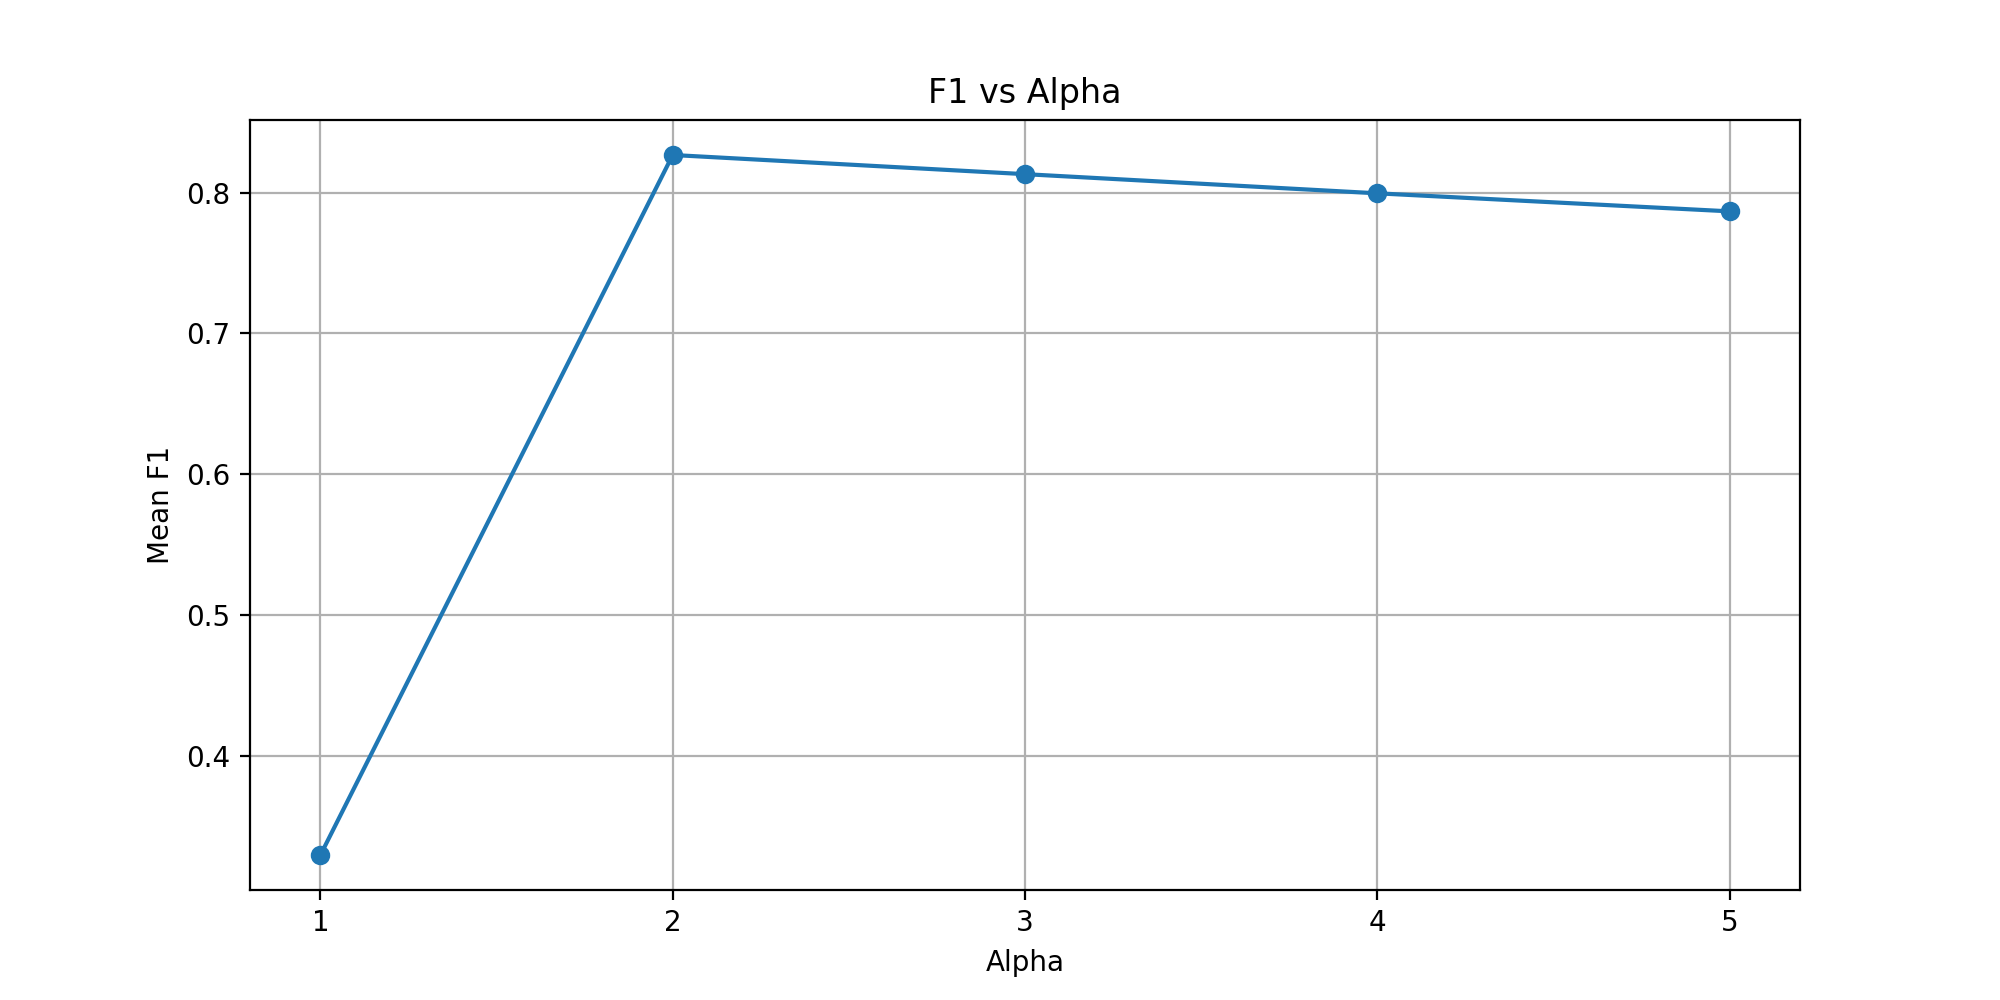

In [35]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, f1s, marker='o')
plt.title('F1 vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean F1')
plt.xticks(alphas)
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


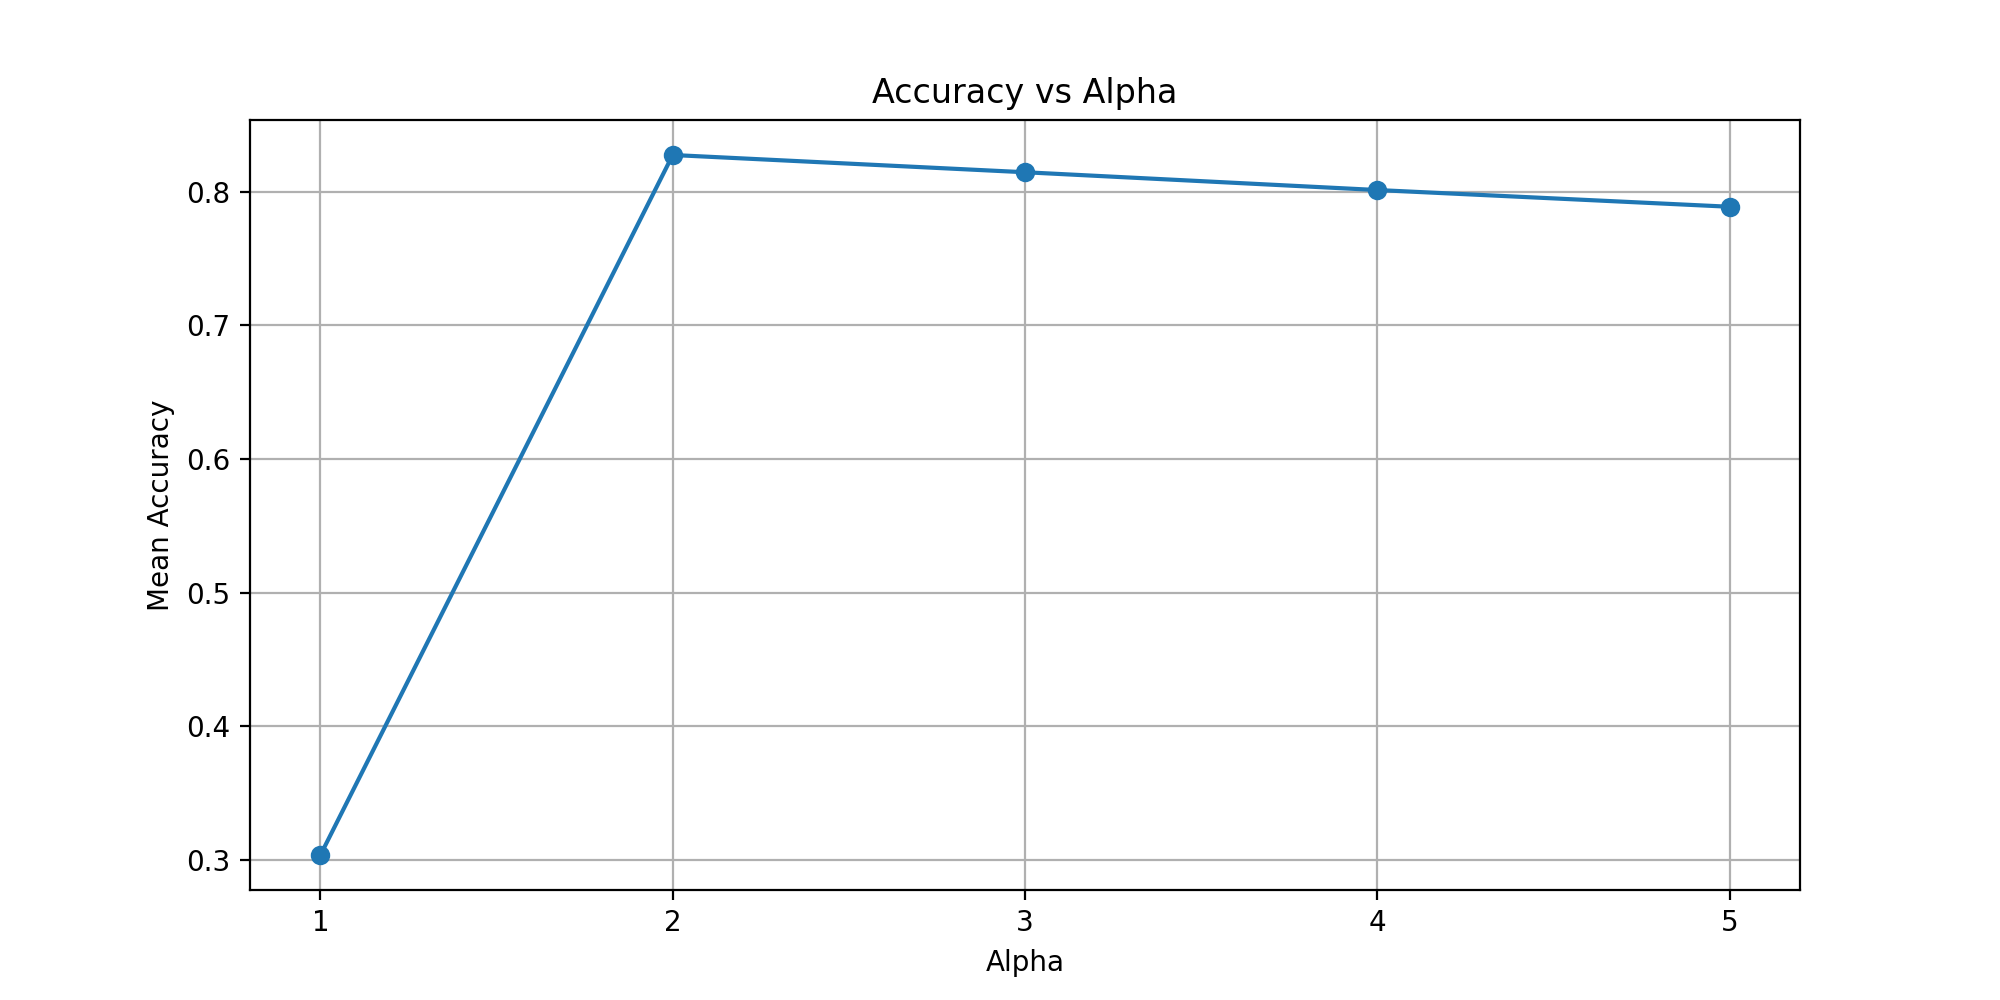

In [36]:
plt.figure(figsize=(10, 5))
plt.plot(alphas, accs, marker='o')
plt.title('Accuracy vs Alpha')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy')
plt.xticks(alphas)
plt.grid()
plt.show()

# 5 Generating Data

In [37]:
def nb_generate(model, ygen):
    """Given a Naive Bayes model, generate some data.

    Parameters
    ----------
    model : dict
        A Naive Bayes model trained with nb_train.
    ygen : nd_array of shape (n,)
        Vector of class labels for which to generate data.

    Returns
    -------
    nd_array of shape (n,D)

    Generated data. The i-th row is a sampled data point for the i-th label in
    ygen.
    """
    logcls = model["logcls"]
    n = len(ygen)
    C, D, K = logcls.shape
    Xgen = np.zeros((n, D))
    
    for i in range(n):
        c = ygen[i]
        # Generate the i-th example of class c, i.e., row Xgen[i,:]. To sample
        # from a categorical distribution with parameter theta (a probability
        # vector), you can use np.random.choice(range(K),p=theta).
        # YOUR CODE HERE
        
        for j in range(D):
            sum_exp = np.sum(np.exp(logcls[c][j]))
            
            theta = np.zeros(K)
            theta = np.exp(logcls[c][j])/sum_exp
            
            Xgen[i, j] = np.random.choice(range(K), p=theta)
        
    return Xgen

<IPython.core.display.Javascript object>


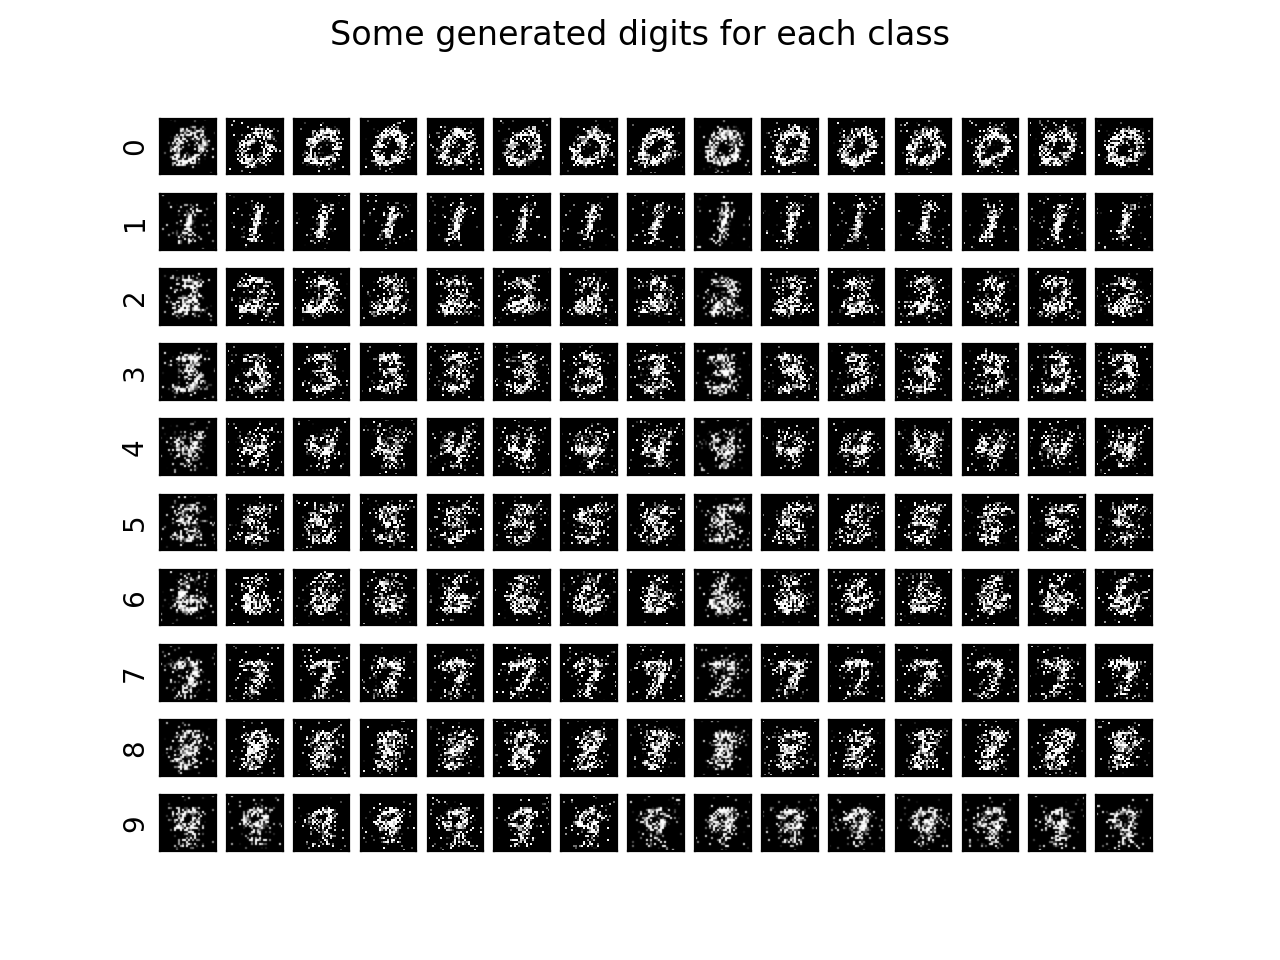

Text(0.5, 0.98, 'Some generated digits for each class')

In [39]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nb2, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

<IPython.core.display.Javascript object>


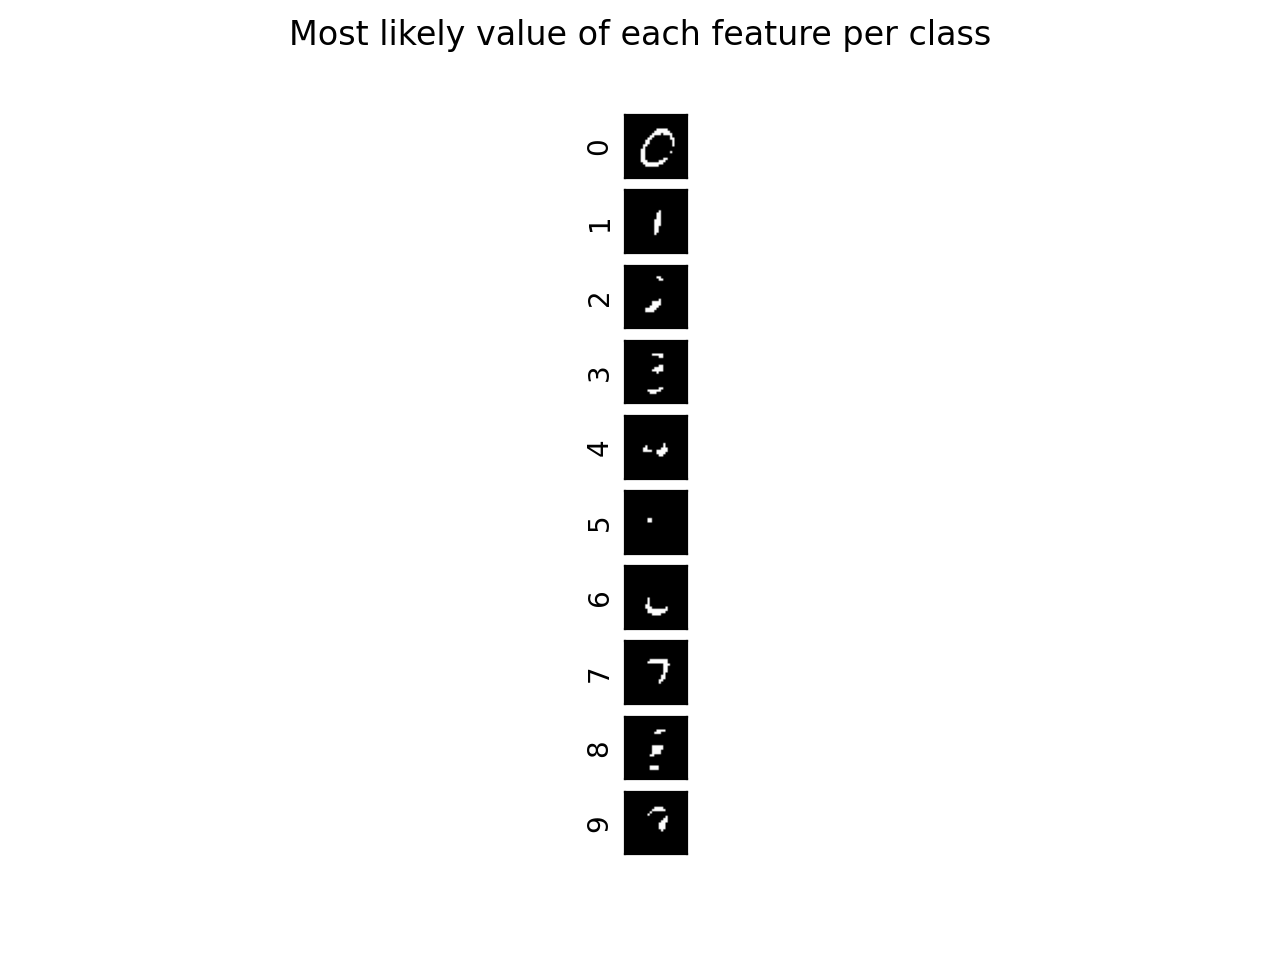

Text(0.5, 0.98, 'Most likely value of each feature per class')

In [40]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nb2["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

<IPython.core.display.Javascript object>


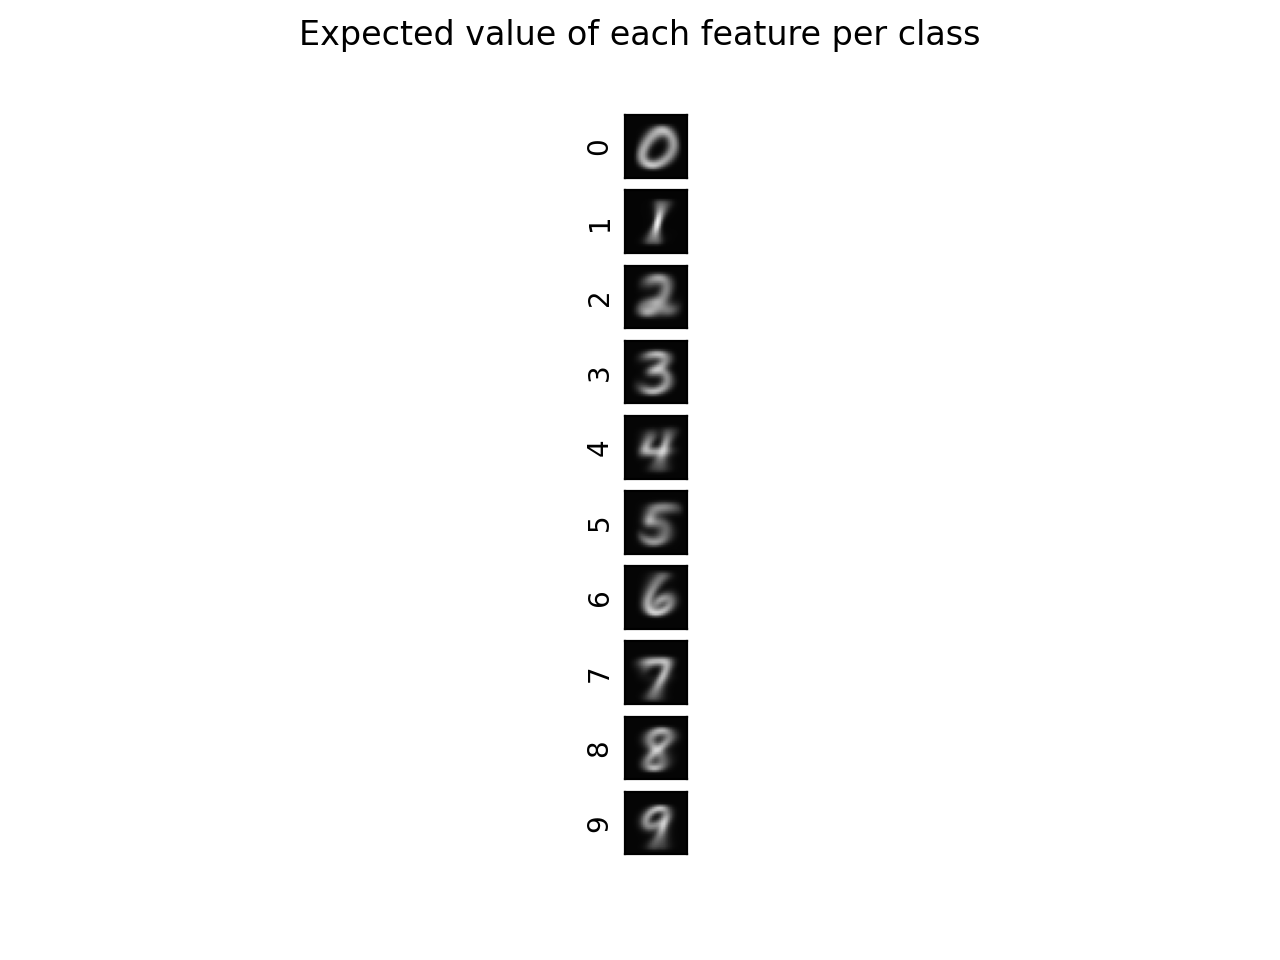

Text(0.5, 0.98, 'Expected value of each feature per class')

In [41]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nb2["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")

## with different alphas

In [42]:
alpha_val = 4
model_nbs = nb_train(X, y, alpha=alpha_val)

<IPython.core.display.Javascript object>


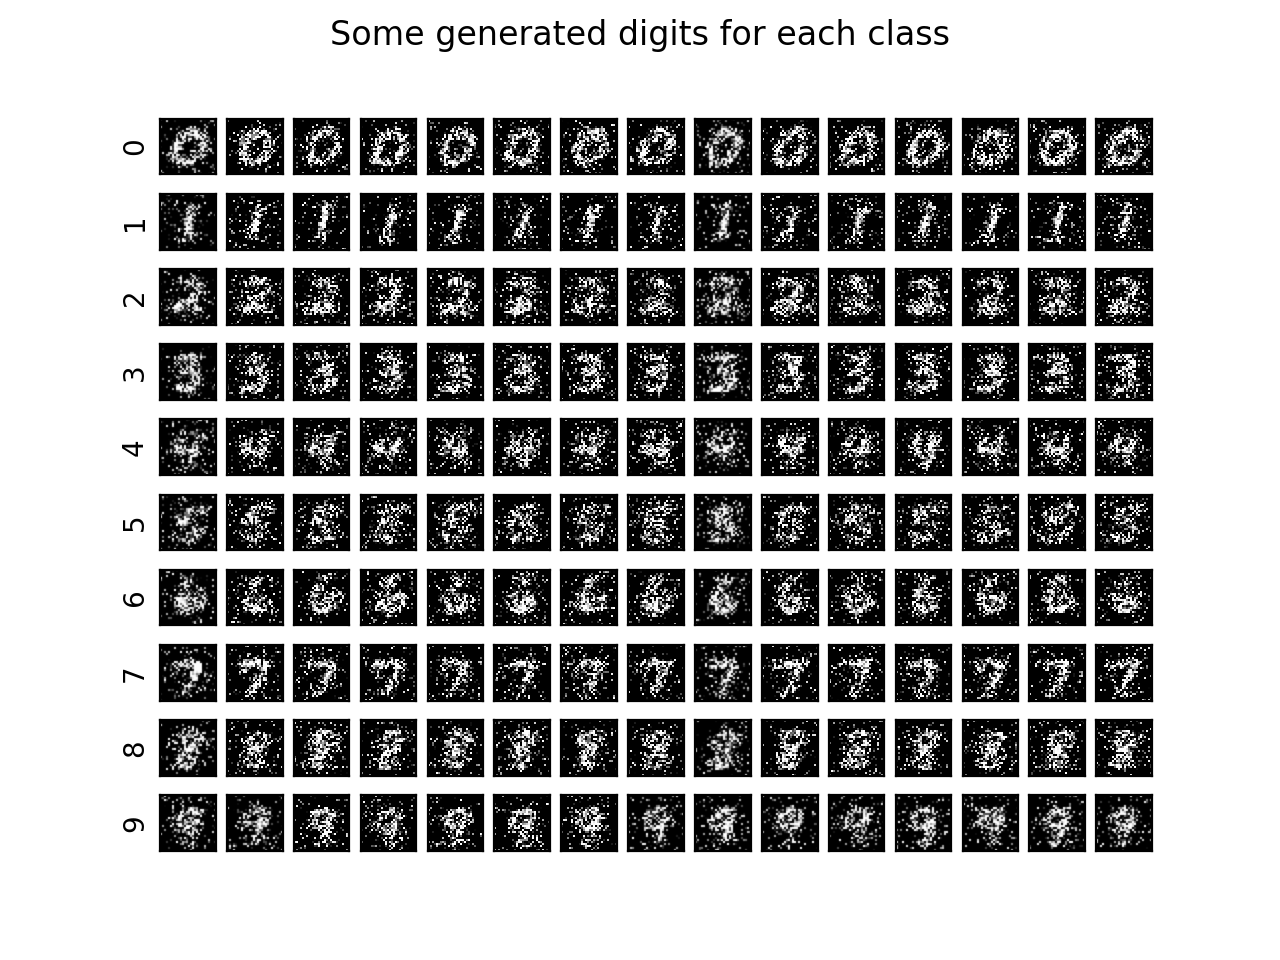

Text(0.5, 0.98, 'Some generated digits for each class')

In [43]:
# let's generate 15 digits from each class and plot
ygen = np.repeat(np.arange(10), 15)
Xgen = nb_generate(model_nbs, ygen)

nextplot()
showdigits(Xgen, ygen)
plt.suptitle("Some generated digits for each class")

<IPython.core.display.Javascript object>


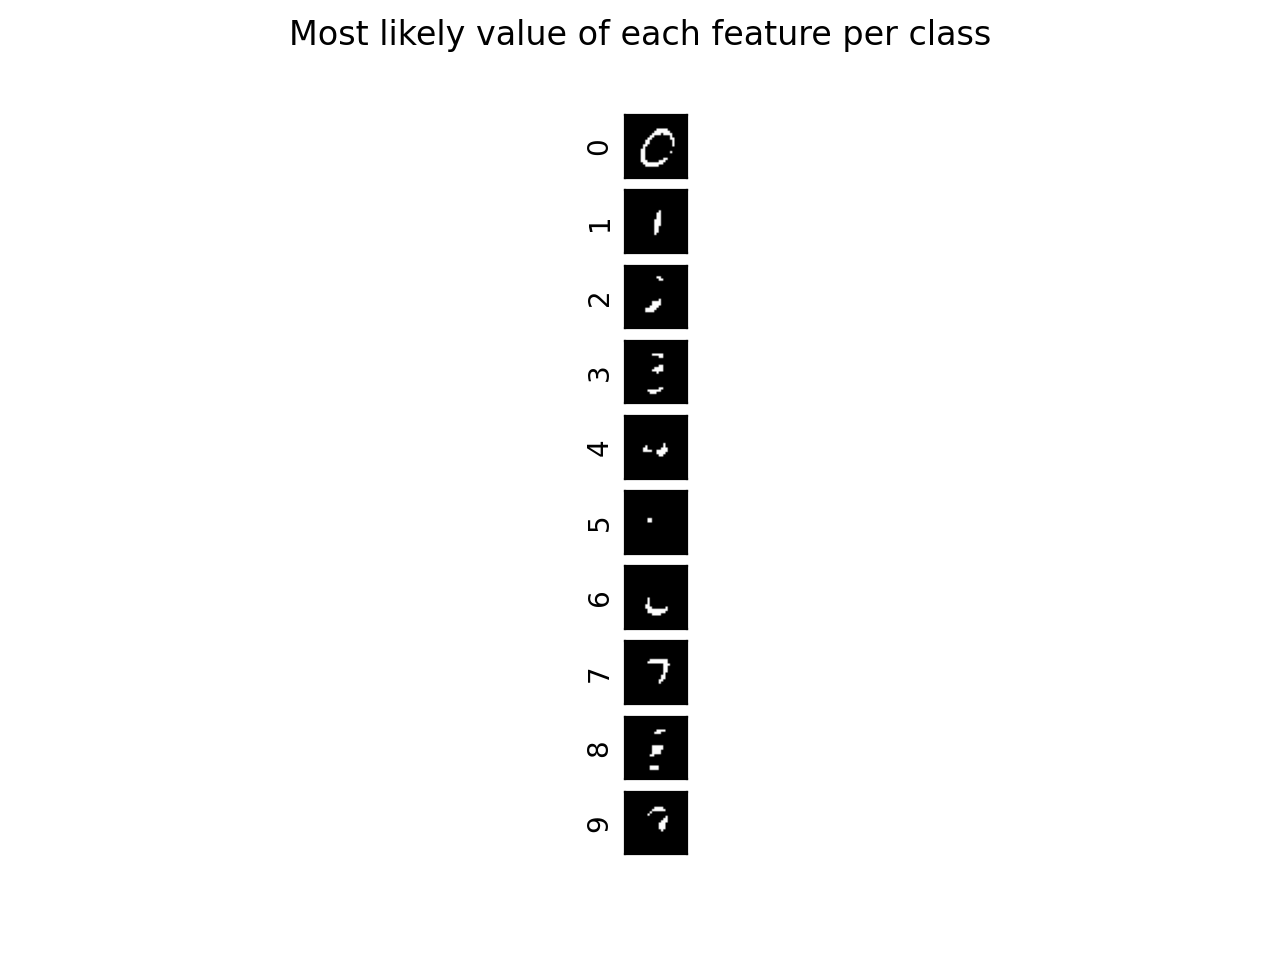

Text(0.5, 0.98, 'Most likely value of each feature per class')

In [44]:
# we can also plot the parameter vectors by choosing the most-likely
# value for each feature
ymax = np.arange(10)
Xmax = np.zeros((10, D))
for c in range(10):
    Xmax[c,] = np.apply_along_axis(np.argmax, 1, model_nbs["logcls"][c, :, :])

nextplot()
showdigits(Xmax, ymax)
plt.suptitle("Most likely value of each feature per class")

<IPython.core.display.Javascript object>


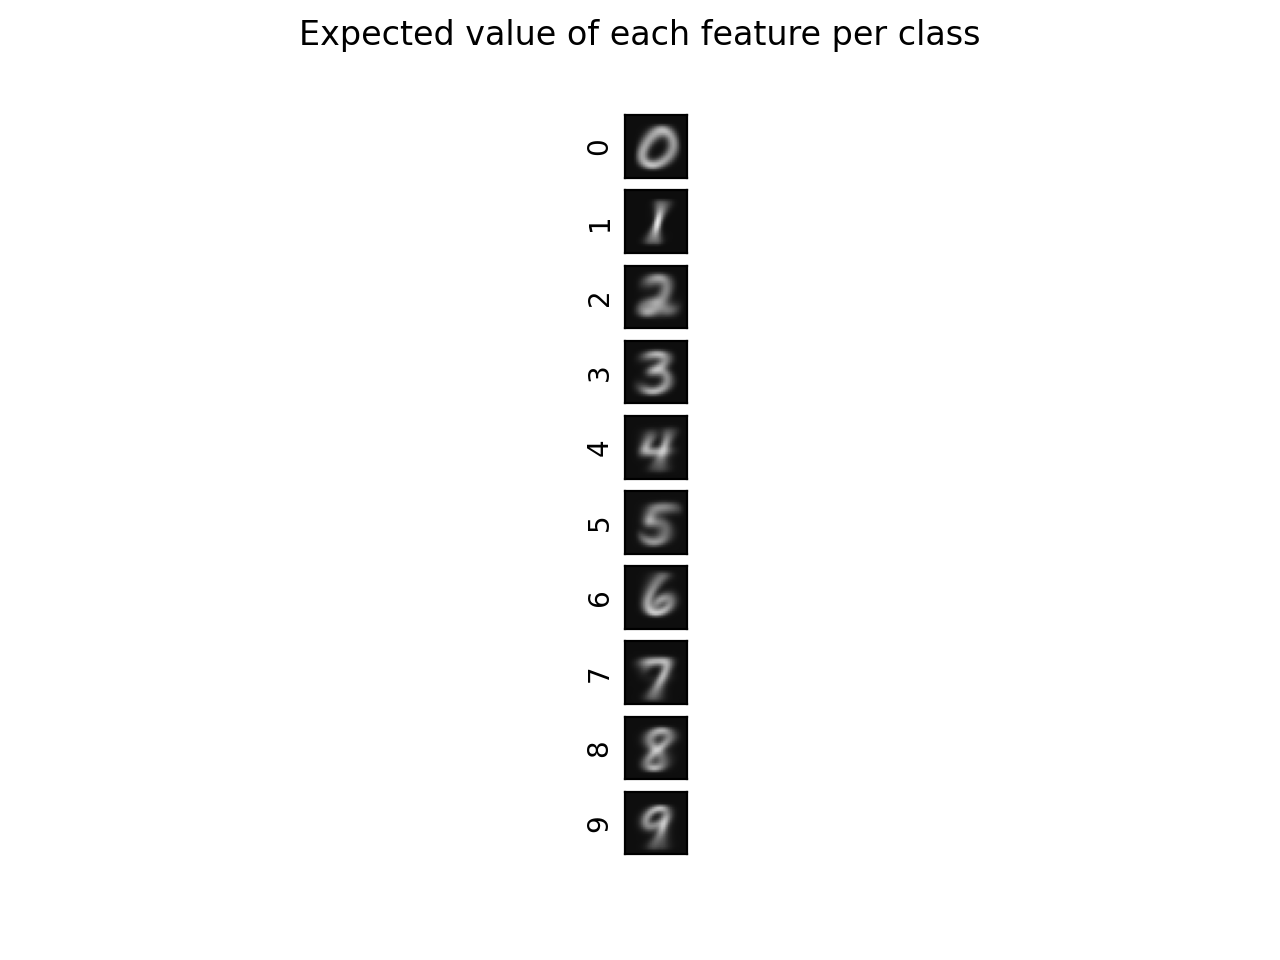

Text(0.5, 0.98, 'Expected value of each feature per class')

In [45]:
# Or the expected value of each feature. Here we leave the categorical domain
# and treat each feature as a number, i.e., this is NOT how categorical Naive
# Bayes sees it and we wouldn't be able to do this if the data were really
# categorical.
ymean = np.arange(10)
Xmean = np.zeros((10, D))
for c in range(10):
    Xmean[c,] = np.apply_along_axis(
        np.sum, 1, np.exp(model_nbs["logcls"][c, :, :]) * np.arange(256)
    )

nextplot()
showdigits(Xmean, ymean)
plt.suptitle("Expected value of each feature per class")